In [1]:
import joblib
import pandas as pd
from engineering import EngineeringTransformer

import warnings
warnings.filterwarnings("ignore")

pipeline = joblib.load('../pipelines/feature_engineering_pipeline.joblib')
df = pd.read_csv("../data/orig_train.csv")
df = pipeline.fit_transform(df)
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)


# Testing models

In [2]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

y_val = df_val['FINALIZED_LOAN']
X_val = df_val.drop(columns="FINALIZED_LOAN")


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def my_cross_validate(models, X_train, y_train, scoring, cv=6, n_jobs=-1):
    rows = len(models)
    cols = len(scoring)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    all_scores = {}
    base_results = cross_validate(DummyClassifier(strategy="uniform"), X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)
    base_scores = [(name, base_results[name]) for name in base_results if name.startswith("test_")] 
    all_scores["base"] = base_scores
    
    labels = ['Fold {}'.format(i) for i in range(1, cv + 1)]
    x = np.arange(len(labels))
    width = 0.35
    
    for j, model in enumerate(models):
        cv_results = cross_validate(model, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)

        model_name = model.__class__.__name__.split(".")[-1]
        scores = [(name[len("test_"):], cv_results[name]) for name in cv_results if name.startswith("test_")] 
        all_scores[model_name] = scores
        
        for i, (name, score) in enumerate(scores):
            org_i = i
            i += j * len(scoring)
            
            mean_score = np.mean(score)
            std_score = np.std(score)
            base_score = np.mean(base_scores[org_i][1])
            
            # print(f"{name:.10s} - mean score: {mean_score:2.6f}, std: {std_score:2.6f}. Precise: {score}")

            bars = sns.barplot(x=x, y=score, ax=axes[i], color='skyblue')
            axes[i].axhline(y=mean_score, color='red', linestyle='--', label=f'Mean ({mean_score:1.3f})')
            axes[i].axhline(y=mean_score + std_score, color='orange', linestyle='--', label=f"+- std ({std_score:1.3f})")
            axes[i].axhline(y=mean_score - std_score, color='orange', linestyle='--')
            axes[i].axhline(y=base_score, color='green', linestyle='-.', label=f"Base score ({base_score:1.3f})")
            
            if org_i == 0:
                axes[i].set_ylabel(f"{model_name}")
            if j == 0:
                axes[i].set_title(f"{name}")
            axes[i].set_xticklabels(labels)
            axes[i].set_xticks(x)
            axes[i].set_ylim(0, 1)
            
            for bar, precise_score in zip(bars.patches, score):
                axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 0.1, f'{precise_score:.2f}', 
                            ha='center', va='bottom', fontsize=8, color='black')

            axes[i].legend(fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.xlabel('Fold')
    plt.tight_layout()
    plt.show()

    return all_scores

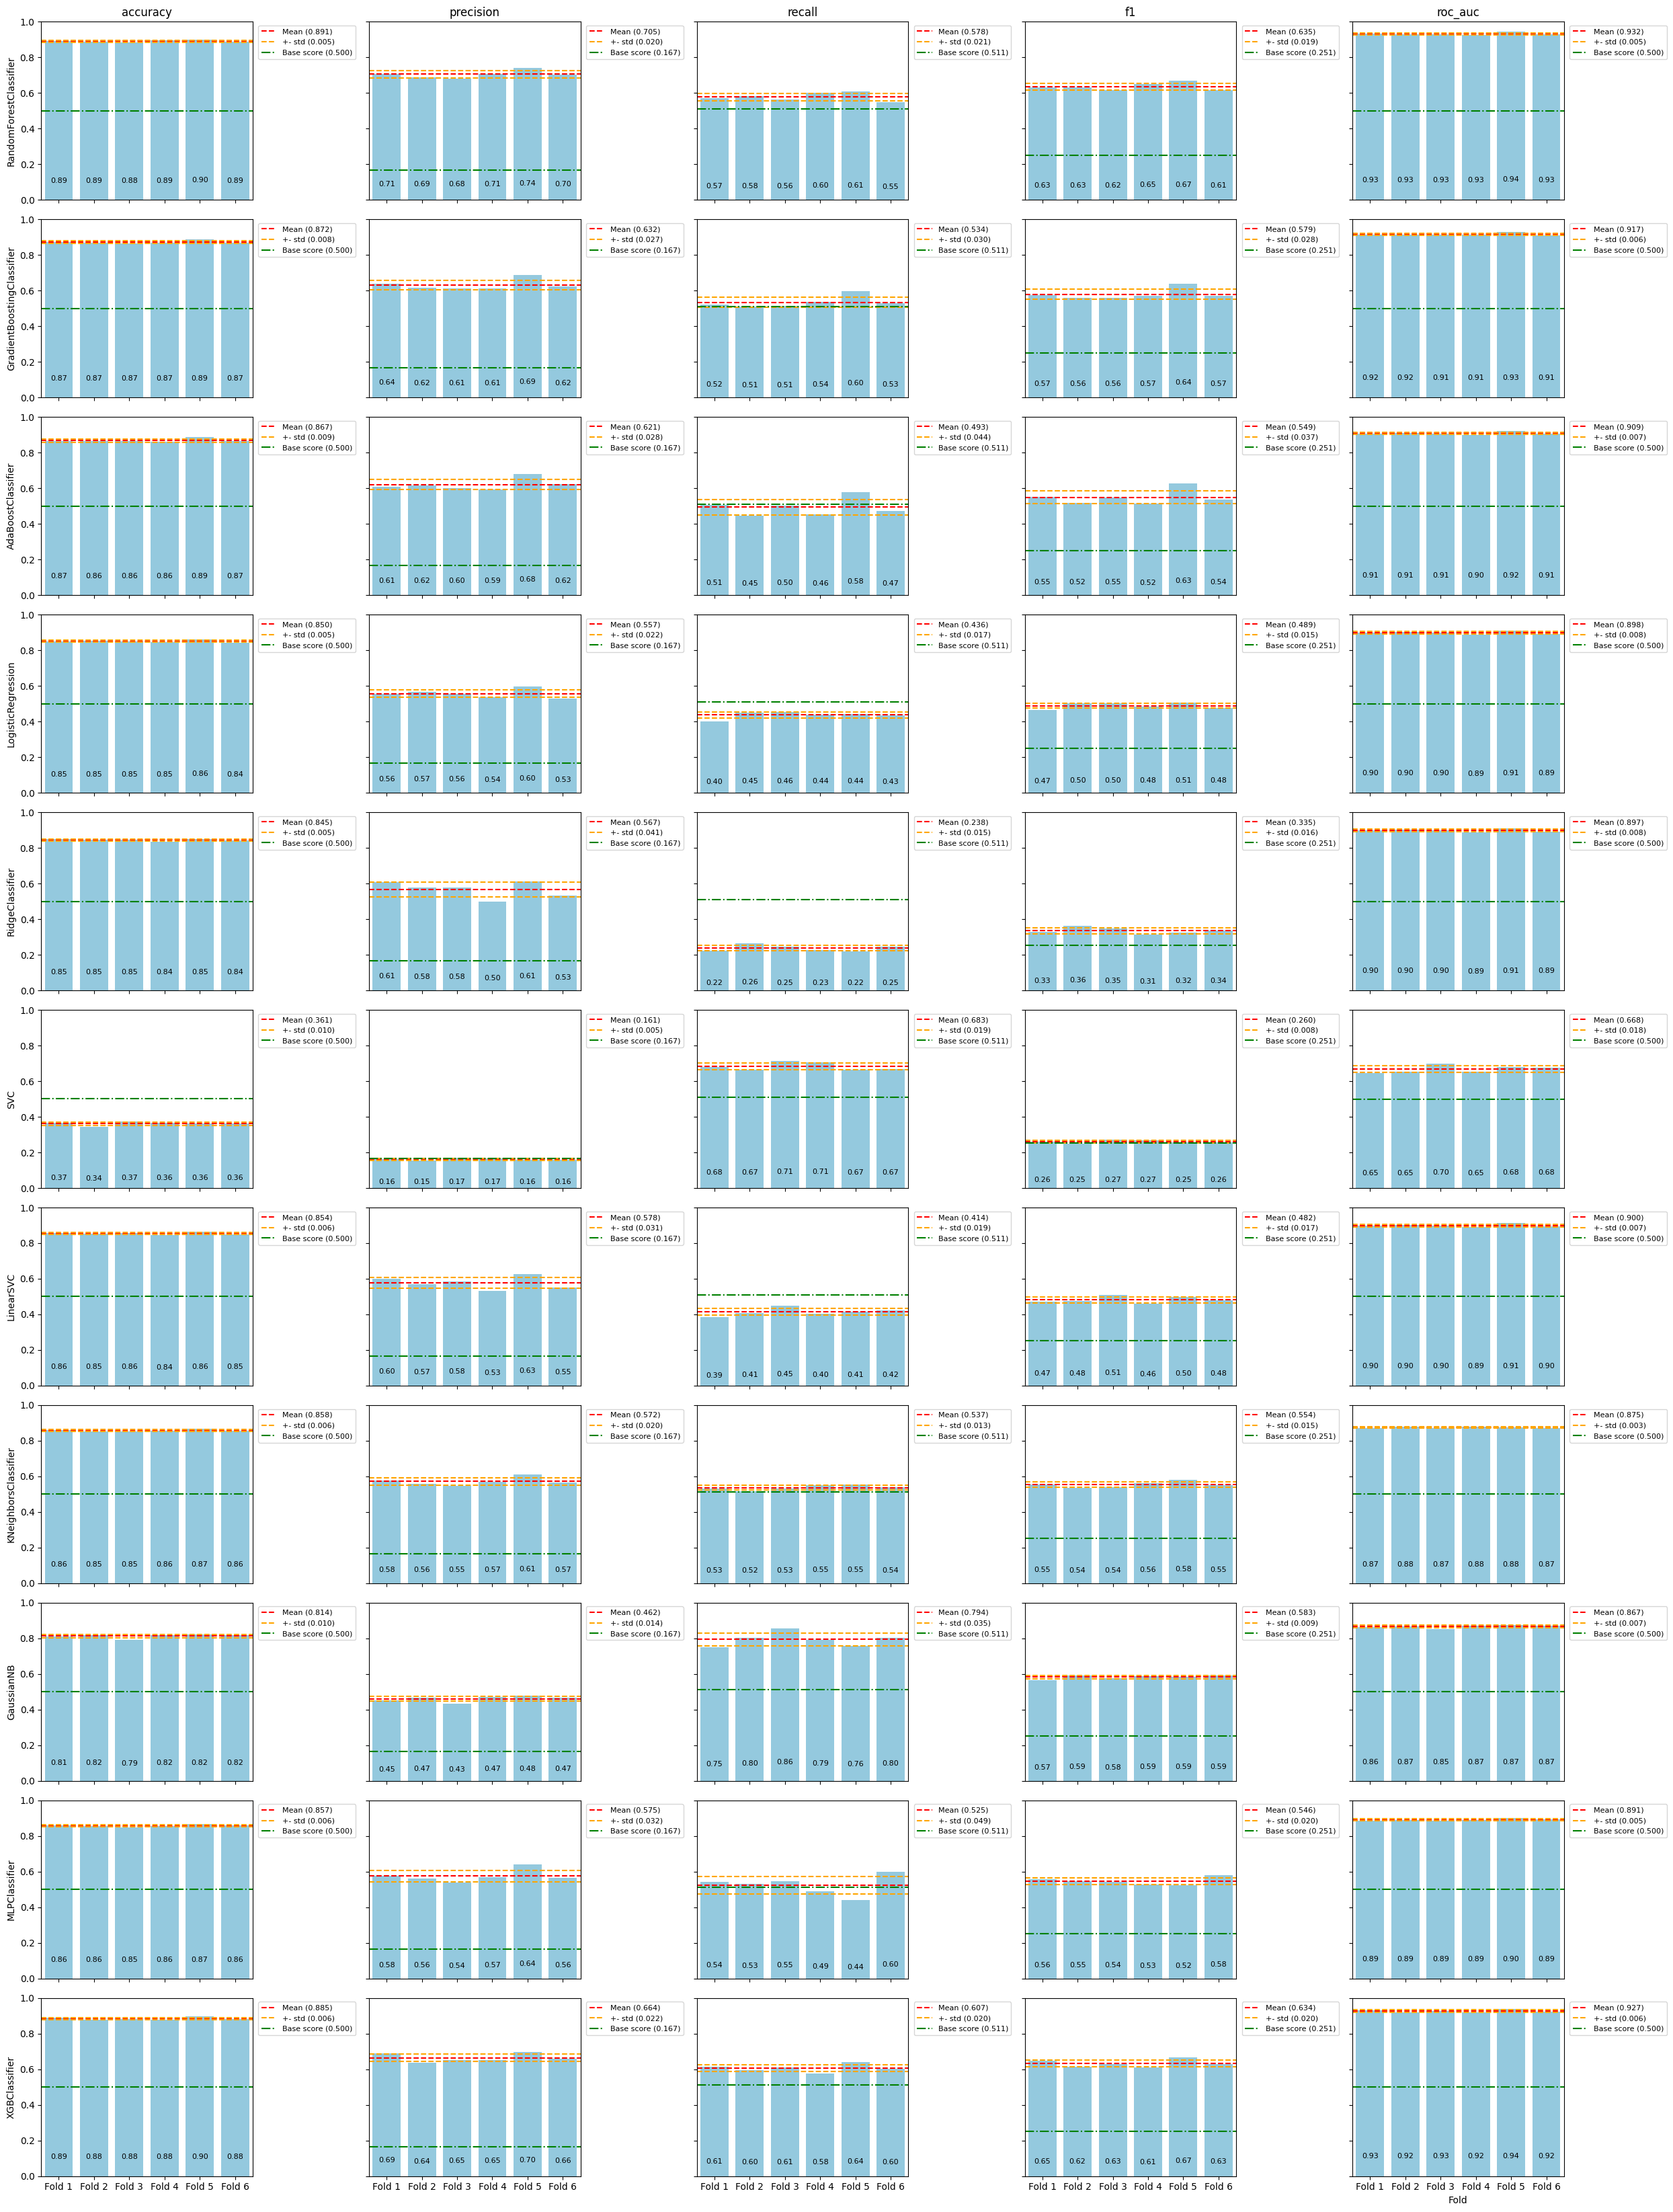

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 

models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

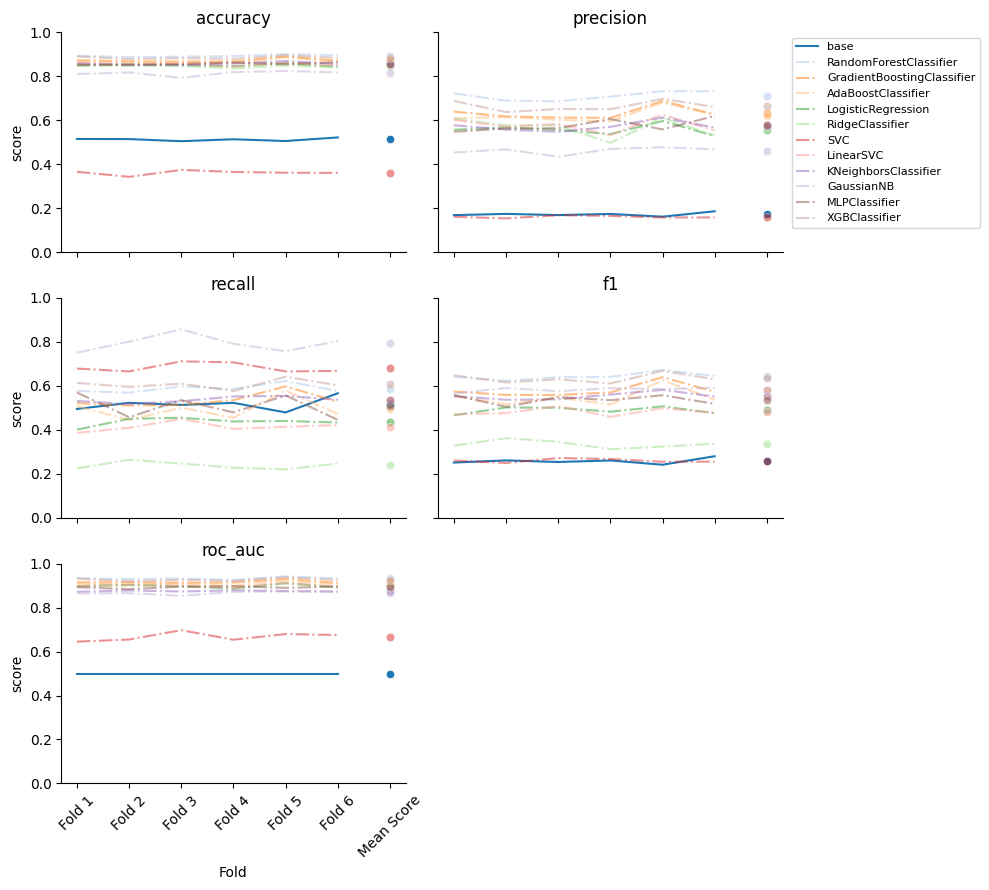

In [11]:
def plot_scoring(scoring, scores):
    plt.figure(figsize=(12, 8))
    sns.set_palette(sns.color_palette("tab20"))

    cv = len(list(scores.values())[0][1][1])
    rows = int(np.ceil(len(scoring) / 2))
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for model_name, model_scores in scores.items():
        for i, (metric_name, metric_scores) in enumerate(model_scores):
            linestyle='-.'
            alpha=0.5
            if model_name == "base":
                linestyle = "-"
                alpha=1
            sns.lineplot(x=range(len(metric_scores)), y=metric_scores, label=f'{model_name}', ax=axes[i], linestyle=linestyle, alpha=alpha)
    
            sns.scatterplot(x=[len(metric_scores)], y=[np.mean(metric_scores)], ax=axes[i], alpha=alpha)

    for i in range(len(scoring)):
        for j, (model_name, _) in enumerate(scoring.items()):
            axes[j].set_title(f"{model_name}")
            
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False) 
        axes[i].set_ylim(0, 1)
        axes[i].get_legend().remove()
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel('score')
        
        axes[i].set_xticklabels([f'Fold {i+1}' if i < cv else 'Mean Score' for i in range(-1, cv + 1)])
        axes[i].tick_params(axis='x', rotation=45)
        
    axes[min(len(scoring) - 1, cols - 1)].legend(fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')

    for i in range(rows * cols, len(scoring), -1):
        axes[i - 1].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_scoring(scoring, scores)

Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

In [5]:
import shap
shap.initjs()


NameError: name 'clf' is not defined

In [6]:
shap.plots.bar(shap_values[:,:,1],max_display=10)

NameError: name 'shap_values' is not defined

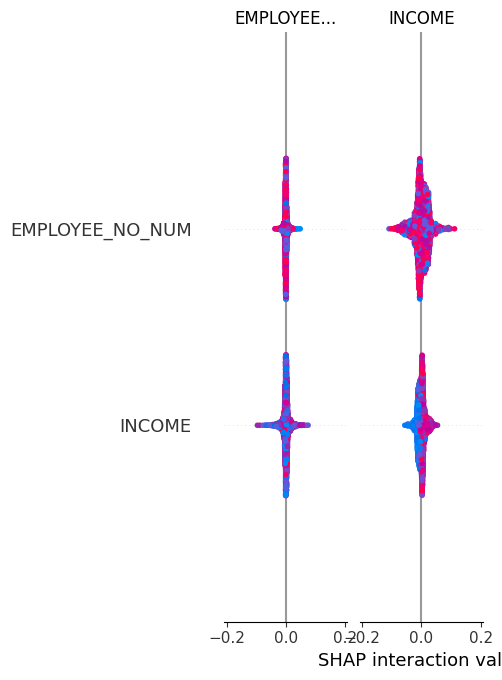

In [16]:
shap.summary_plot(shap_values, X_val)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [8]:
from sklearn.metrics import classification_report,roc_auc_score
clf = models[0]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_pred, y_val))
print(f"ROC AUC score: {roc_auc_score(y_val, y_pred)}")

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2824
           1       0.56      0.69      0.62       411

    accuracy                           0.89      3235
   macro avg       0.76      0.80      0.78      3235
weighted avg       0.90      0.89      0.90      3235

ROC AUC score: 0.7578453188721314


In [9]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_val)

In [11]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_val)

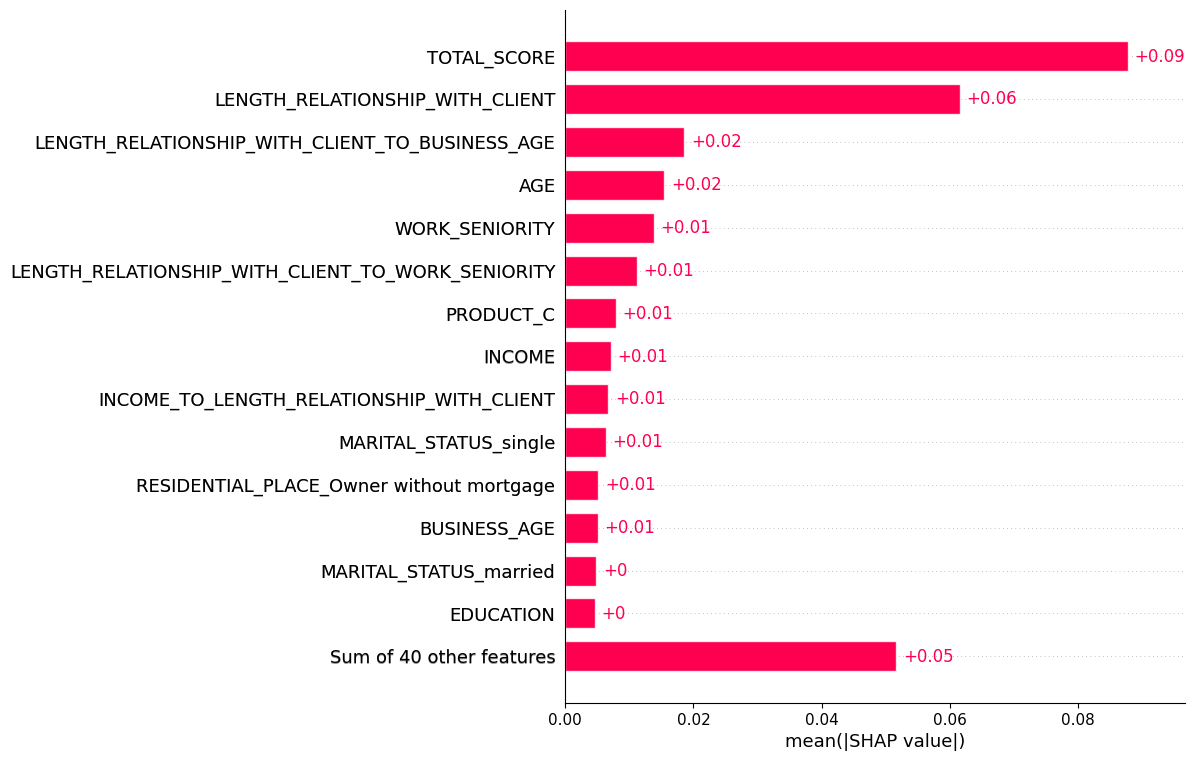

In [16]:
shap.plots.bar(shap_values[:,:,1],max_display=15) # credit to Katarzyna Rogalska

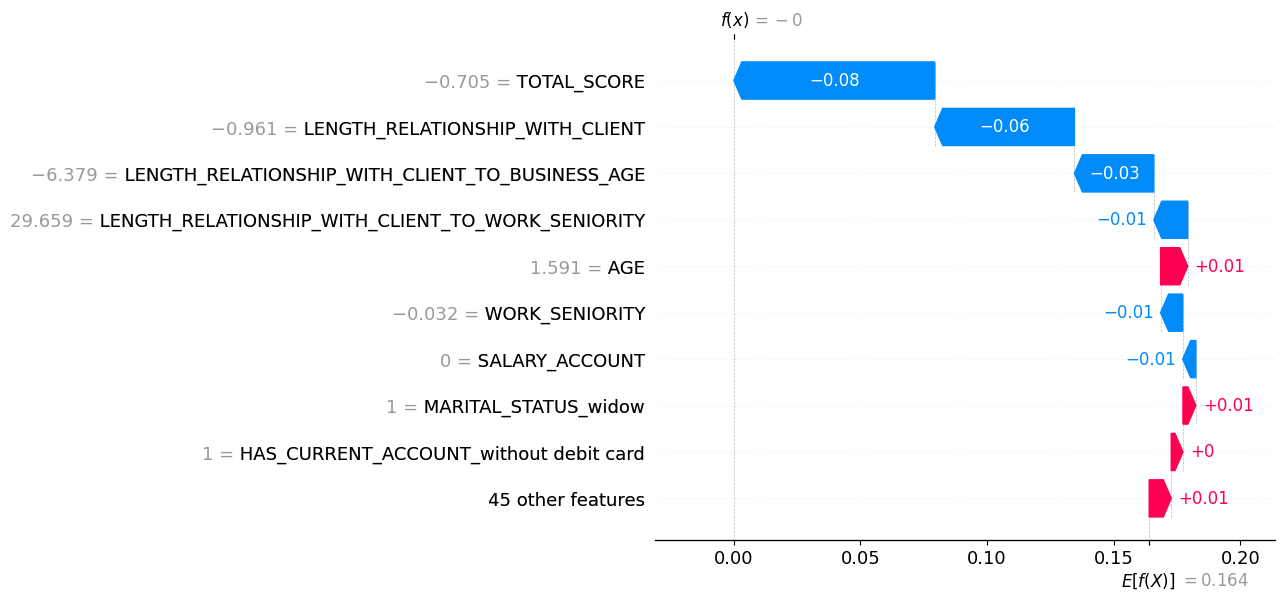

In [25]:
shap.waterfall_plot(shap_values[:,:,1][102])

In [8]:
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.metrics import AUC

In [9]:
def get_model():
  
  input_layer = Input(shape=(X_train.shape[1],))
  x = Dense(128, activation='relu')(input_layer)
  x = Dense(64, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  output_layer = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=input_layer, outputs=output_layer)
  model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics=[AUC()])
  return model

In [10]:
model = get_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
history = model.fit(X_train,
                    y_train,
                    batch_size=256,
                    epochs=300,
                    validation_split= 0.2,
                    shuffle = True ,
                    verbose=1,
                    )

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.5125 - loss: 0.7191 - val_auc: 0.5729 - val_loss: 0.5076
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6498 - loss: 0.4855 - val_auc: 0.6816 - val_loss: 0.4498
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7207 - loss: 0.4302 - val_auc: 0.7452 - val_loss: 0.4151
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7730 - loss: 0.4055 - val_auc: 0.7901 - val_loss: 0.3900
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8028 - loss: 0.3751 - val_auc: 0.8252 - val_loss: 0.3703
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8337 - loss: 0.3662 - val_auc: 0.8438 - val_loss: 0.3538
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8547 - loss: 0.3415 - val_auc: 0.8618 - val_loss: 0.3382
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8744 - loss: 0.3226 - val_auc: 0.8711 - val_loss: 0.3263
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8813

In [13]:
import matplotlib.pyplot as plt

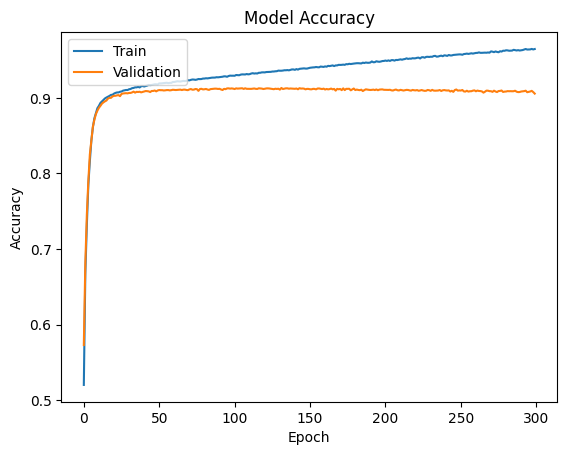

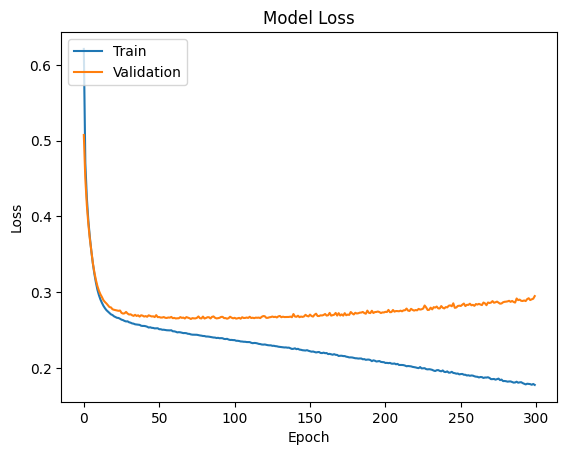

In [15]:
# Plot accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model = get_model()
history = model.fit(X_train,
                    y_train,
                    batch_size=256,
                    epochs=30,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc_1: 0.4230 - loss: 0.8631 - val_auc_1: 0.5749 - val_loss: 0.5003
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.6129 - loss: 0.4755 - val_auc_1: 0.7133 - val_loss: 0.4290
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.7289 - loss: 0.4143 - val_auc_1: 0.7693 - val_loss: 0.3935
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.7822 - loss: 0.3868 - val_auc_1: 0.8122 - val_loss: 0.3695
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8179 - loss: 0.3633 - val_auc_1: 0.8395 - val_loss: 0.3491
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8392 - loss: 0.3438 - val_auc_1: 0.8598 - val_loss: 0.3321
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8638 - loss: 0.3261 - val_auc_1: 0.8714 - val_loss: 0.3191
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8700 - loss: 0.3104 - val_auc_1: 0.8817 - val_loss: 0.3078
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

In [20]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
preds = model.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)

# Calculate ROC AUC score


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2734
           1       0.55      0.50      0.52       501

    accuracy                           0.86      3235
   macro avg       0.73      0.71      0.72      3235
weighted avg       0.85      0.86      0.86      3235

ROC AUC score: 0.8999221746704105
